# Imports

In [ ]:
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import numpy as np
import math
from scipy.signal import convolve2d

# Defined Functions

In [ ]:
# by https://stackoverflow.com/a/25436112
def estimate_noise(I):

  if I.shape[2] != 1:
    I = cv2.cvtColor(I, cv2.COLOR_RGB2GRAY)

  H, W = I.shape

  M = [[1, -2, 1],
       [-2, 4, -2],
       [1, -2, 1]]

  sigma = np.sum(np.sum(np.absolute(convolve2d(I, M))))
  sigma = sigma * math.sqrt(0.5 * math.pi) / (6 * (W-2) * (H-2))

  return sigma

def draw_line(img,rho,theta):
  a = np.cos(thetas[theta])
  b = np.sin(thetas[theta])
  x0 = a*rhos[rho]
  y0 = b*rhos[rho]
  # these are then scaled so that the lines go off the edges of the image
  x1 = int(x0 + 1000*(-b))
  y1 = int(y0 + 1000*(a))
  x2 = int(x0 - 1000*(-b))
  y2 = int(y0 - 1000*(a))
  cv2.line(img, (x1, y1), (x2, y2), (0, 0, 255), 2)


def remove_neighbour_lines(accumulator,neigh=3):
  acc_copy = accumulator.copy()
  for i in range(0,accumulator.shape[0],neigh):
    if i+neigh > accumulator.shape[0]:
      continue
    for j in range(0,accumulator.shape[1],neigh):
      if j+neigh > accumulator.shape[1]:
        continue
      filter = np.zeros((neigh,neigh))
      idx = np.argmax(accumulator[i:i+neigh,j:j+neigh])
      x,y = np.unravel_index(idx, (neigh,neigh))
      filter[x][y] = 1
      acc_copy[i:i+neigh,j:j+neigh]= accumulator[i:i+neigh,j:j+neigh]*filter 
  return acc_copy

# Read Image

shape of the image(704, 1279, 3)


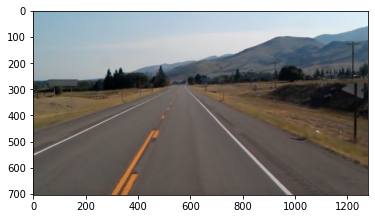

In [ ]:
original_img = cv2.cvtColor(cv2.imread("/content/testHough.jpg"),cv2.COLOR_BGR2RGB)
plt.imshow(original_img)
print(f"shape of the image{original_img.shape}")

# Resize

shape of the image(480, 720, 3)


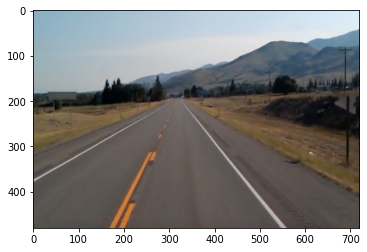

In [ ]:
resized_img = cv2.resize(original_img,dsize=(720,480))
plt.imshow(resized_img)
print(f"shape of the image{resized_img.shape}")

# Smoothing

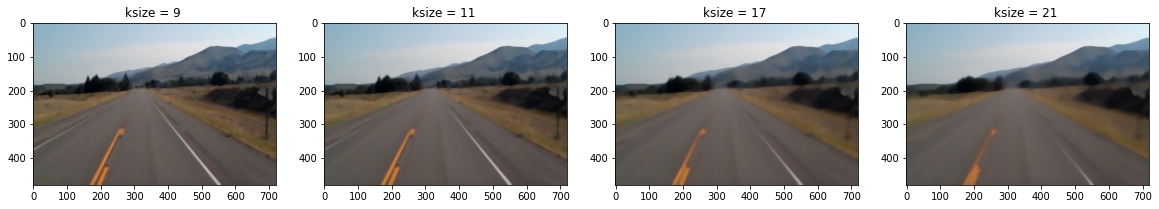

In [ ]:
test_kernels = [9,11,17,21]
fig,ax=plt.subplots(nrows=1,ncols=len(test_kernels),figsize=(20,8))
for i in range(len(test_kernels)):
  test = cv2.medianBlur(resized_img,ksize=test_kernels[i])
  ax[i].title.set_text(f"ksize = {test_kernels[i]} ")
  ax[i].imshow(test)

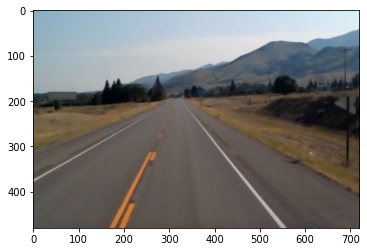

In [ ]:
smoothed_img = cv2.medianBlur(resized_img,ksize=5)
plt.imshow(smoothed_img)

# Edge Detection Using Canny Alg.

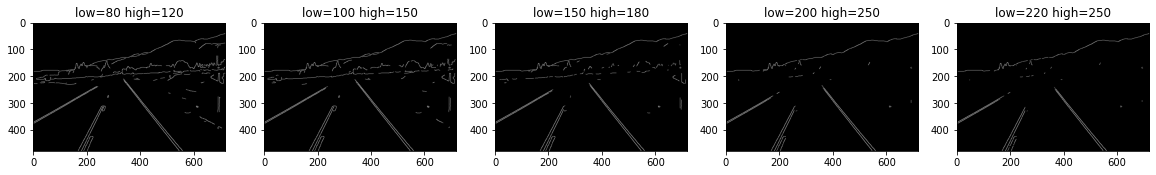

In [ ]:
test_bounds = [
    [80,120],
    [100,150],
    [150,180],
    [200,250],
    [220,250],
]
fig,ax=plt.subplots(nrows=1,ncols=len(test_bounds),figsize=(20,8))
for i in range(len(test_bounds)):
  t_lower = test_bounds[i][0]  # Lower Threshold
  t_upper = test_bounds[i][1]  # Upper threshold
  test = cv2.Canny(smoothed_img, t_lower, t_upper)
  ax[i].title.set_text(f"low={t_lower} high={t_upper}")
  ax[i].imshow(test,cmap='gray')

In [ ]:
edged_img = cv2.Canny(smoothed_img, 200, 250)
print(edged_img.shape)
print(np.unique(edged_img))

(480, 720)
[  0 255]


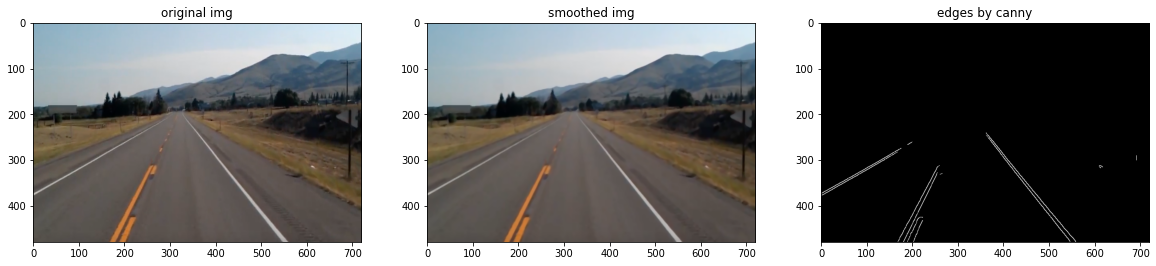

In [ ]:
fig,ax=plt.subplots(nrows=1,ncols=3,figsize=(20,8))
ax[0].imshow(resized_img)
ax[0].title.set_text("original img")
ax[1].imshow(smoothed_img)
ax[1].title.set_text("smoothed img")
ax[2].imshow(edged_img,cmap='gray')
ax[2].title.set_text("edges by canny")


# ROI (not the best approach)

In [ ]:
edged_img[:240,:] = 0 

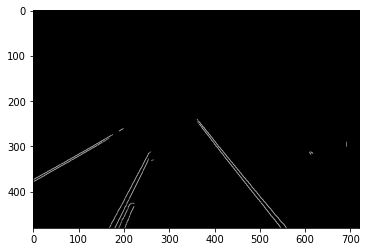

In [ ]:
plt.imshow(edged_img,cmap='gray')

# Hough Transform

In [ ]:
def hough_transform(image):
  H,W = image.shape

  # Max diatance is diagonal one 
  Maxdist = int(np.ceil(np.sqrt(H**2 + W ** 2)))
  # Theta in range from 0 to 180 degrees
  thetas = np.deg2rad(np.arange(0, 180))
  # Range of radius
  rs = np.linspace(-Maxdist, Maxdist, 2*Maxdist)
  accumulator = np.zeros((2 * Maxdist, len(thetas)),dtype=np.uint64)
  y_idxs, x_idxs = np.nonzero(image)  # (row, col) indexes to edges

  for i in range(len(x_idxs)):
    x = x_idxs[i]
    y = y_idxs[i]
    for k in range(len(thetas)):
      p = np.round(x*np.cos(thetas[k]) + y*np.sin(thetas[k])) + Maxdist # to avoid negative values
      accumulator[int(p),k] += 1
  return accumulator, thetas, rs

866
180


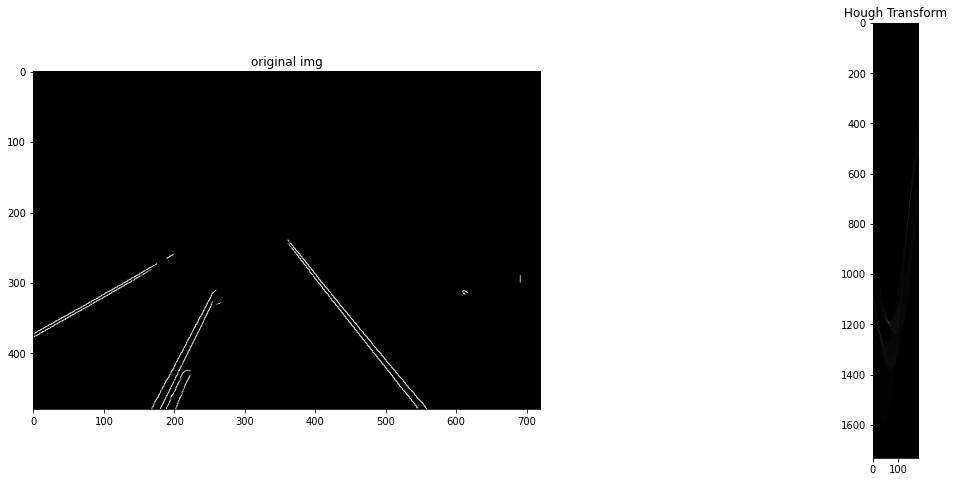

In [ ]:
accumulator, thetas, rhos = hough_transform(edged_img)
fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(20,8))
ax[0].imshow(edged_img,cmap='gray')
ax[0].title.set_text("original img")
ax[1].imshow(accumulator,cmap='gray',)
ax[1].title.set_text("Hough Transform")

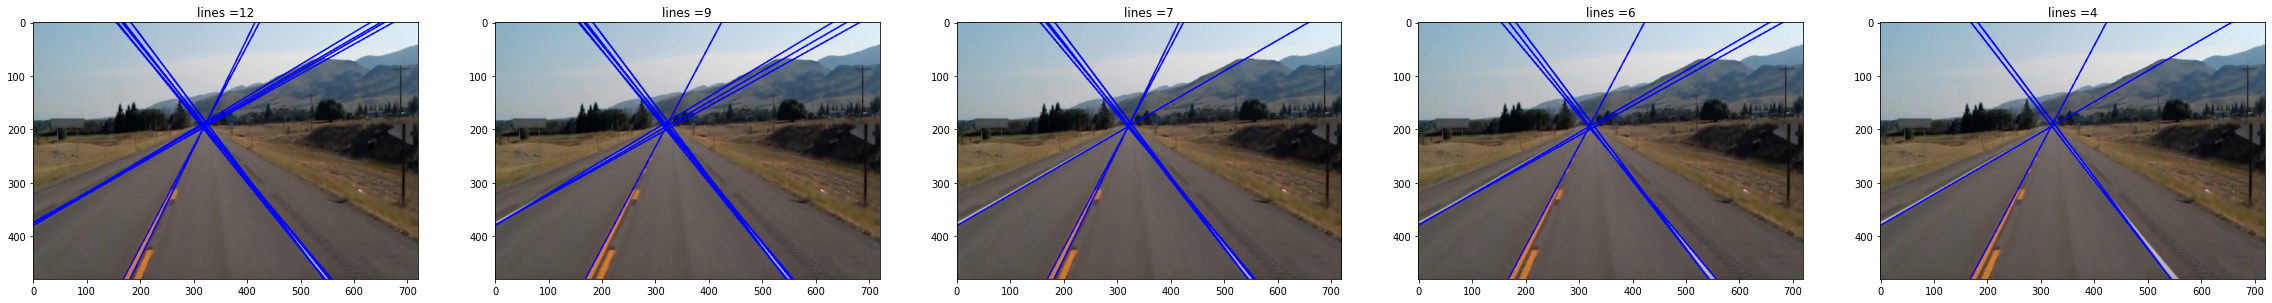

In [ ]:
THRESHOLD = 100
test_neigh = [3,5,7,13,17]
fig,ax=plt.subplots(nrows=1,ncols=len(test_neigh),figsize=(20,8))
for k in range(len(test_neigh)):
  test_acc = remove_neighbour_lines(accumulator,test_neigh[k])
  test_img = resized_img.copy()
  line_count = 0
  for i in range(test_acc.shape[0]):
    for j in range(test_acc.shape[1]):
      if test_acc[i][j] > THRESHOLD:
        line_count += 1
        draw_line(test_img,i,j)
        ax[k].title.set_text(f"lines ={line_count}")
        ax[k].imshow(test_img)

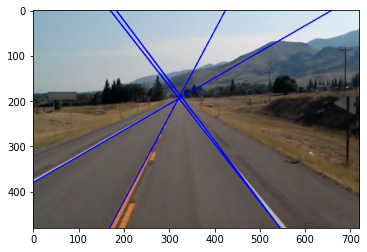

In [ ]:
plt.imshow(test_img)